In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn .linear_model import LogisticRegression
from mlxtend .feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import learning_curve

KeyError: 'scale'

In [2]:
pd.set_option("display.max_columns",3000)  #this allows us to view up to 3000 columns when printing a dataframe
pd.set_option("display.max_rows",3000)  #this allows us to view up to 3000 rows when printing a dataframe

## Concealment Prediction

##### In this section, we'll use "framesDropped" field in order to predict the concealment of video and "concealmentEvents" field for concealment of audio - so 2 different problems. Firstly, we'll check if there are any concealment (seperately in each of them, audio and video, using corresponding fields as anticipated above) using classification method. Then, for the cases where concealment are predicted as present we'll use Regression to predict the exact value of that Concealemnt.

#### Func-1: Input data

In [3]:
def inp_data(data_val):
    global dataFrame
    global dataFrame_1
    
    global X_train
    global X_test
    global X_train_main
    global X_test_main
    
    dataFrame=pd.read_csv("Train_1000ms_unbalanced.csv")  #reading train dataSet file
    dataFrame_1=pd.read_csv("Test_1000ms_unbalanced.csv")  #reading test dataSet file
    
    #Selection of all training data I thought it would be useful to count on:
    drp_1=dataFrame.iloc[:,0:27]
    drp_2=dataFrame.loc[:,"flow":"p_type"]
    X_train = dataFrame.drop(drp_1+drp_2,axis=1) #axis=0 indicates rows, axis=1 indicates columns
    X_train = X_train.drop(X_train.loc[:,'rtp_csrc_csrc_agg':'inter_time_sequence_max_value_count_percent'],axis=1)
    
    X_test = dataFrame_1.loc[:, X_train.columns]
    
    #Dintinguish between audio and video packets as below:
    if data_val == "audio":
        dataFrame=dataFrame[dataFrame["kind"]=="audio"]
        dataFrame_1=dataFrame_1[dataFrame_1["kind"]=="audio"]
        
        # Remove the data corresponding to concealmentEvents=-1 since it means NO DATA were collected about it
        dataFrame = dataFrame[dataFrame["concealmentEvents"]!=-1]
        dataFrame_1 = dataFrame_1[dataFrame_1["concealmentEvents"]!=-1]
        #NOTE: Here it comes out the problem, when we extract -1s we have no data representing the NO CONCEALMENT case. That's why we expect an accuracy 100% in classification process
        
        
    else:
        dataFrame=dataFrame[dataFrame["kind"]=="video"]
        dataFrame_1=dataFrame_1[dataFrame_1["kind"]=="video"]
        
        # Remove the data corresponding to framesDropped=-1 since it means NO DATA were collected about it
        dataFrame = dataFrame[dataFrame["framesDropped"]!=-1]
        dataFrame_1 = dataFrame_1[dataFrame_1["framesDropped"]!=-1]
        

#### Func-2) Preparing the target by extracting the cumulative values from each other

In [4]:
def extract(data_typ):
    global dataFrame
    global dataFrame_1
    print("\n We're doing the extraction process")
    if data_typ == "audio":
        # Assign the differences between contiguous values (by using groupby and .diff) to a new column called: "exact_audio_concealment".
        #This is done because the values in "concealmentEvents" field are cumulative (so summed u of each other)
        dataFrame["exact_audio_concealment"] = dataFrame.groupby(['flow', 'pcap']).concealmentEvents.diff()    #Groups the data based on flow and pcap fields (takes all rows one-by-one) and after each row it check for any matching combination field in previous rows, if there is a match group (flow-pcap) it extracts the previous value of concealmentEvents from the one currently in hand, if no matching is found (especially in the first comparision) then NaN is written.
    
        # Do the same thing for Audio test dataset too
        dataFrame_1["exact_audio_concealment"] = dataFrame_1.groupby(['flow', 'pcap']).concealmentEvents.diff()    #Groups the data based on flow and pcap fields (takes all rows one-by-one) and after each row it check for any matching combination field in previous rows, if there is a match group (flow-pcap) it extracts the previous value of concealmentEvents from the one currently in hand, if no matching found then NaN is written.
            
    else:
        # Assign the differences between contiguous values (by using groupby and .diff) to a new column called: "exact_video_concealment"
        dataFrame["exact_video_concealment"] = dataFrame.groupby(['flow', 'pcap']).framesDropped.diff()    #Groups the data based on flow and pcap fields (takes all rows one-by-one) and after each row it check for any matching combination field in previous rows, if there is a match group (flow-pcap) it extracts the previous value of concealmentEvents from the one currently in hand, if no matching found then NaN is written.
    
        # Do the same thing for Video testing dataset too
        dataFrame_1["exact_video_concealment"] = dataFrame_1.groupby(['flow', 'pcap']).framesDropped.diff()    #Groups the data based on flow and pcap fields (takes all rows one-by-one) and after each row it check for any matching combination field in previous rows, if there is a match group (flow-pcap) it extracts the previous value of concealmentEvents from the one currently in hand, if no matching found then NaN is written.
        

#### Func-3) Classification process

In [5]:
def classif(data_val):
    global dataFrame
    global dataFrame_1
    
    global X_train
    global X_test
    global y_train
    global y_test
    global tar_no
    
    #Adjust the dataset and training/test dataset in order to be used for CLASSIFICATION method
    if data_val=="audio":
        # Here we create a new column (for simplification purposes) which contains only 2 classes, "1" indicating the presence of CONCEALMENT and "0" indicating there are NOT. 
        dataFrame.loc[(dataFrame['exact_audio_concealment'] != 0), 'Aud_CONCEALMENT_Present?'] = 1
        dataFrame.loc[(dataFrame['exact_audio_concealment'] == 0), 'Aud_CONCEALMENT_Present?'] = 0
    
        # Same thing as above also for testing dataset
        dataFrame_1.loc[(dataFrame_1['exact_audio_concealment'] != 0), 'Aud_CONCEALMENT_Present?'] = 1 
        dataFrame_1.loc[(dataFrame_1['exact_audio_concealment'] == 0), 'Aud_CONCEALMENT_Present?'] = 0
        
        # This recently created column will be used as "TARGET" field to predict whether there is any CONCEALMENT or not using CLASSIFICATION.
        y_train = dataFrame["Aud_CONCEALMENT_Present?"]
        y_test = dataFrame_1["Aud_CONCEALMENT_Present?"]
        y_train = y_train.dropna()
        y_test = y_test.dropna()
        X_train = X_train.loc[y_train.index]   #balance the indexes of X_train to those of y_train (since many rows were dropped above)
        X_test = X_test.loc[y_test.index]      #balance the indexes of X_test to those of y_test (since many rows were dropped above)
        
        
    elif data_val=="video":
        tar_no=input("Do you want 2 groups (0s and 1s) or 3 groups (0s, positives and negative): ")
        if tar_no=='2':
            # Here we create a new column (for simplification purposes) which contains only 2 classes, "1" indicating the presence of CONCEALMENT and "0" indicating there are NOT. 
            dataFrame.loc[(dataFrame['exact_video_concealment'] != 0), 'Vid_CONCEALMENT_Present?'] = 1
            dataFrame.loc[(dataFrame['exact_video_concealment'] == 0), 'Vid_CONCEALMENT_Present?'] = 0
    
            # Same thing as above also for testing dataset
            dataFrame_1.loc[(dataFrame_1['exact_video_concealment'] != 0), 'Vid_CONCEALMENT_Present?'] = 1 
            dataFrame_1.loc[(dataFrame_1['exact_video_concealment'] == 0), 'Vid_CONCEALMENT_Present?'] = 0
        
            # This recently created column will be used as "TARGET" field to predict whether there is any CONCEALMENT or not using CLASSIFICATION.
            y_train = dataFrame["Vid_CONCEALMENT_Present?"]
            y_test = dataFrame_1["Vid_CONCEALMENT_Present?"]
            y_train = y_train.dropna()
            y_test = y_test.dropna()
            X_train = X_train.loc[y_train.index]
            X_test = X_test.loc[y_test.index]
            
            
        elif tar_no=='3':
            dataFrame.loc[(dataFrame['exact_video_concealment'] < 0), 'Vid_CONCEALMENT_Present?'] = -1
            dataFrame.loc[(dataFrame['exact_video_concealment'] == 0), 'Vid_CONCEALMENT_Present?'] = 0
            dataFrame.loc[(dataFrame['exact_video_concealment'] > 0), 'Vid_CONCEALMENT_Present?'] = 1
            
            dataFrame_1.loc[(dataFrame_1['exact_video_concealment'] < 0), 'Vid_CONCEALMENT_Present?'] = -1
            dataFrame_1.loc[(dataFrame_1['exact_video_concealment'] == 0), 'Vid_CONCEALMENT_Present?'] = 0
            dataFrame_1.loc[(dataFrame_1['exact_video_concealment'] > 0), 'Vid_CONCEALMENT_Present?'] = 1
            
            y_train = dataFrame["Vid_CONCEALMENT_Present?"]
            y_test = dataFrame_1["Vid_CONCEALMENT_Present?"]
            y_train = y_train.dropna()
            y_test = y_test.dropna()
            X_train = X_train.loc[y_train.index]
            X_test = X_test.loc[y_test.index]

#### Func-4: Decision Tree Classifier

In [6]:
def dec_tree_class(dat_typ):
    global predictions
    
    de_tree_clsf = DecisionTreeClassifier()  #enable the decision tree classifier
    de_tree_clsf.fit(X_train,y_train)  #fit the model with x_train and y_train
    predictions = de_tree_clsf.predict(X_test)  # test the trained model with unseen data (X_tets in our case) and see
    
    # Evaluate the performance of that CLASSIFICATION
    print(confusion_matrix(y_test,predictions))
    if dat_typ=="audio":
        plot_confusion_matrix(de_tree_clsf, X_test, y_test,
                                     display_labels=["0","1"],
                                     cmap=plt.cm.Blues,
                                     normalize=None)         #Confusion matrix plot
    
    elif dat_typ=="video":
        if tar_no=='2':
            plot_confusion_matrix(de_tree_clsf, X_test, y_test,
                                         display_labels=["0","1"],
                                         cmap=plt.cm.Blues,
                                         normalize=None)         #Confusion matrix plot
        
        elif tar_no=='3':
            plot_confusion_matrix(de_tree_clsf, X_test, y_test,
                                         display_labels=["-1","0","1"],
                                         cmap=plt.cm.Blues,
                                         normalize=None)         #Confusion matrix plot
        
    print(classification_report(y_test,predictions))
    print("Accuracy score is:", accuracy_score(y_test, predictions))


#### Func-5: Random Forest Classifier

In [7]:
def rand_for_class(dat_typ):
    global predictions
    
    r_forest = RandomForestClassifier()  #enable the Random Forest Classifier
    r_forest.fit(X_train,y_train)  #fit the model with x_train and y_train
    predictions = r_forest.predict(X_test)
    
    #Evaluation process
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    print(confusion_matrix(y_test,predictions))
    if dat_typ=="audio":
        plot_confusion_matrix(r_forest, X_test, y_test,
                                     display_labels=["0","1"],
                                     cmap=plt.cm.Blues,
                                     normalize=None)         #Confusion matrix plot
    
    elif dat_typ=="video":
        if tar_no=='2':
            plot_confusion_matrix(r_forest, X_test, y_test,
                                         display_labels=["0","1"],
                                         cmap=plt.cm.Blues,
                                         normalize=None)         #Confusion matrix plot
        
        elif tar_no=='3':
            plot_confusion_matrix(r_forest, X_test, y_test,
                                         display_labels=["-1","0","1"],
                                         cmap=plt.cm.Blues,
                                         normalize=None)         #Confusion matrix plot
            
    print(classification_report(y_test,predictions))
    print("Accuracy score is:", accuracy_score(y_test, predictions))
    

#### Func-6: Select the most appropriate dataset for REGRESSION

In [8]:
def regr(data_typ):
    global dataFrame
    global dataFrame_1
    
    print("Adjusting the dataset in order to proceed with regression")
    if data_typ=="audio":  
        dataFrame_1["Audio_conceal_prediction"]=predictions     #Add a new column to the Audio dataframe, containing all the predictions made above using CLASSIFICATION algorithm. This will help in taking only the packets for which a CONCEALMENT is predicted as existing in order to predict the exact value with regression.
        
        # Train the model using only audio packets for which concealment is present. So I filtered the dataFrame in such a way that only data for which concealment is present will be used.
        dataFrame = dataFrame[dataFrame["Aud_CONCEALMENT_Present?"]==1]     #take only the rows for which concealment is present and assign them to a new dataFrame.
        
        # For testing purposes, we take only the data for which our previous model predicted that there was concealment and based on those data it tries to predict the exact Concealment value for those predicted as CONCEALMENT exists.
        dataFrame_1 = dataFrame_1[dataFrame_1["Audio_conceal_prediction"]==1]  #Take all rows predicted as there was CONCEALMENT and assign them to a new dataFrame
        
        
    else:
        dataFrame_1["Video_conceal_prediction"]=predictions    #Add a new column to the Video dataframe , containing all the predictions made above using CLASSIFICATION algorithm. This will help in taking only the packets for which a CONCEALMENT is predicted as existing.
        
        # Train the model using only video packets for which concealment is present. So I filtered the dataFrame in such a way that only data for which concealment is present will be used.
        dataFrame = dataFrame[dataFrame["Vid_CONCEALMENT_Present?"]==1]     #take only the rows for which concealment is present and assign them to a new dataFrame.
        
        # For testing purposes, we take only the data for which our previous model predicted that there was concealment and based on those data it tries to predict the exact Concealment value for those predicted as CONCEALMENT exists.
        dataFrame_1 = dataFrame_1[dataFrame_1["Video_conceal_prediction"]==1]  #Take all rows predicted as there was CONCEALMENT and assign them to a new dataFrame
         

#### Func-7: Re-adjust the input data (for REGRESSION)

In [9]:
def regre_inp_data(data_typ):
    global X_train
    global X_test
    global y_train
    global y_test
    global X_train_main
    global X_test_main
    
    #print("Input data preparation")
    
    #Selection of all training data I thought it would be useful to count on:
    drp_1=dataFrame.iloc[:,0:27]
    drp_2=dataFrame.loc[:,"flow":"p_type"]
    X_train = dataFrame.drop(drp_1+drp_2,axis=1) #axis=0 indicates rows, axis=1 indicates columns
    X_train = X_train.drop(X_train.loc[:,'rtp_csrc_csrc_agg':'inter_time_sequence_max_value_count_percent'],axis=1)  
    X_test = dataFrame_1.loc[:, X_train.columns]
    
    if data_typ == "audio":
        y_train = dataFrame["exact_audio_concealment"]   #Target train, taken from the selected data
        y_test = dataFrame_1["exact_audio_concealment"]    #Target test, taken from the selected data predicted as there are concealments.
        
        #Drop the non-numerical values and equalize the number of indexes accordingly in order to avoid missmatches
        y_train = y_train.dropna()
        y_test = y_test.dropna()
        X_train = X_train.loc[y_train.index]
        X_test = X_test.loc[y_test.index]
        
    else:
        y_train = dataFrame["exact_video_concealment"]   #Target train, taken from the selected data
        y_test = dataFrame_1["exact_video_concealment"]    #Target test, taken from the selected data predicted as there are concealments.
        
        #Drop the non-numerical values and equalize the number of indexes accordingly in order to avoid missmatches
        y_train = y_train.dropna()
        y_test = y_test.dropna()
        X_train = X_train.loc[y_train.index]
        X_test = X_test.loc[y_test.index]
        
    

#### Func-8: Decision Tree Regressor

In [10]:
def dec_tree_reg():
    de_tree = DecisionTreeRegressor()  #enable the decision tree regressor
    de_tree.fit(X_train,y_train)  #fit the model with x_train and y_train
    pred = de_tree.predict(X_test)  # test the trained model with unseen data (X_tets in our case) and see
    
    #Evaluation process:
    from sklearn.metrics import r2_score
    R2 = r2_score(pred, y_test)
    print("R2 score is:",R2)
    
    from sklearn.metrics import mean_absolute_error as mae
    MAE = mae(pred,y_test)
    print ("Mean Absolute Error is:",MAE)
    

#### Func-9: Random Forest Regression

In [11]:
def rand_for_reg():
    #use "global" in order to be able to modify a previously defined global varible inside a function
    global X_train
    global X_test
    global y_train
    global y_test
    
    Rand_for = RandomForestRegressor()
    Rand_fit = Rand_for.fit(X_train, y_train)
    pred = Rand_fit.predict(X_test)
        
    from sklearn.metrics import r2_score
    R2 = r2_score(pred, y_test)
    print("R2 score is:",R2)
        
    from sklearn.metrics import mean_absolute_error as mae
    MAE = mae(pred, y_test)
    print ("Mean Absolute Error is:",MAE)
        
    from sklearn.metrics import mean_squared_error as mse
    MSE = mse (pred, y_test)
    print ("Mean Squared Error:", MSE)

#### Func-10) Feature Selection for CLASSIFICATION only

In [12]:
def feat_sel(sel_meth):
    global X_train
    global X_test
    global y_train
    global y_test
    global X_selected
    
    
    if sel_meth == "ExtraTree":
        print(f"The feature selection method being used is {sel_meth}")
        model = ExtraTreesClassifier()
        model.fit(X_train,y_train)
        # print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
        #plot graph of feature importances for better visualization
        feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    
        X_train=X_train.loc[:,feat_importances.nlargest(35).index]        #Use the best 35 fields/columns of the X_train
        #X_test=X_test.loc[:,X_train.columns]  
        y_train = y_train.loc[X_train.index]
        X_test = X_test[X_train.columns]
        y_test = y_test.loc[X_test.index]
        
        print(f'Reduced number of features after {sel_meth} selection method:', X_train.shape)
        
        
    elif sel_meth == "infoGain":
        print(f"The feature selection method being used is {sel_meth}")
        importances = mutual_info_classif(X_train,y_train)
        feat_imp=pd.Series(importances, index=X_train.columns)
        #print(feat_imp.nlargest(30).index)
    
        X_train=X_train.loc[:,feat_imp.nlargest(35).index]        #Use the best 35 fields/columns of the X_train
        #X_test=X_test.loc[:,X_train.columns]
        y_train = y_train.loc[X_train.index]
        X_test = X_test[X_train.columns]
        y_test = y_test.loc[X_test.index]
        
        print(f'Reduced number of features after {sel_meth} selection method:', X_train.shape)

        
    elif sel_meth == "corrCoeff":
        print(f"The feature selection method being used is {sel_meth}")
        cor = X_train.corr()                                   # Apply correlation coefficient
        columns = np.full((cor.shape[0],), True, dtype=bool)
        for i in range(cor.shape[0]):
            for j in range(i+1, cor.shape[0]):
                if cor.iloc[i,j] >= 0.95:                      #Select only the fields having a correlation less than 95%
                    if columns[j]:
                        columns[j] = False
        selected_columns = X_train.columns[columns]
        X_train = X_train[selected_columns]
        y_train = y_train.loc[X_train.index]
        X_test = X_test[X_train.columns]
        y_test = y_test.loc[X_test.index]
        
        print(f'Reduced number of features after {sel_meth} selection method:', X_train.shape)

        
    elif sel_meth == "anova_f":
        print(f"The feature selection method being used is {sel_meth}")
        fvalue_Best = SelectKBest(f_classif, k=30)
        X_kbest = fvalue_Best.fit_transform(X_train, y_train)
        X_train = X_train[X_train.columns[fvalue_Best.get_support()]]    #Use only the fields selected by the feature selection method called "ANOVA F-VALUE"
        y_train = y_train.loc[X_train.index]
        X_test = X_test[X_train.columns]
        y_test = y_test.loc[X_test.index]

        print(f'Reduced number of features using {sel_meth} method:', X_kbest.shape)
    
        #Drop the non-numerical values and equalize the number of indexes accordingly in order to avoid missmatches
        y_train = y_train.dropna()
        y_test = y_test.dropna()
        X_train = X_train.loc[y_train.index]
        X_test = X_test.loc[y_test.index]

#### Funct-10: Feature Selection for both (classification and regression) --> For now will not be used (will be enabled when extending to regression as well, once we have got good results for classification)

In [13]:

"""
def feat_sel(sel_meth, dt_type, feat_sel_typ):
    global X_train
    global X_test
    global y_train
    global y_test
    global X_selected
    
    if feat_sel_typ == "reg":
        print("Feature selection for regression is being used")
        if dt_type=="audio":
            # Target field to be used for column selection
            y_train = dataFrame["exact_audio_concealment"]
            y_test = dataFrame_1["exact_audio_concealment"]
        
        else:
            # Target field to be used for column selection
            y_train = dataFrame["exact_video_concealment"]
            y_test = dataFrame_1["exact_video_concealment"]
    
    elif feat_sel_typ == "class":
        print("Feature selection for classification is being used")
        if dt_type=="audio":
            # Target field to be used for column selection
            y_train = dataFrame["Aud_CONCEALMENT_Present?"]
            y_test = dataFrame_1["Aud_CONCEALMENT_Present?"]
        
        else:
            # Target field to be used for column selection
            y_train = dataFrame["Vid_CONCEALMENT_Present?"]
            y_test = dataFrame_1["Vid_CONCEALMENT_Present?"]
        
        if sel_meth == "ExtraTree":
            print(f"The feature selection method being used is {sel_meth}")
            model = ExtraTreesClassifier()
            model.fit(X_train,y_train)
            # print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
            #plot graph of feature importances for better visualization
            feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    
            X_train=X_train.loc[:,feat_importances.nlargest(35).index]        #Use the best 35 fields/columns of the X_train
            #X_test=X_test.loc[:,X_train.columns]  
            y_train = y_train.loc[X_train.index]
            X_test = X_test[X_train.columns]
            y_test = y_test.loc[X_test.index]
        
            print(f'Reduced number of features after {sel_meth} selection method:', X_train.shape)
        
        
        elif sel_meth == "infoGain":
            print(f"The feature selection method being used is {sel_meth}")
            importances = mutual_info_classif(X_train,y_train)
            feat_imp=pd.Series(importances, index=X_train.columns)
            #print(feat_imp.nlargest(30).index)
    
            X_train=X_train.loc[:,feat_imp.nlargest(35).index]        #Use the best 35 fields/columns of the X_train
            #X_test=X_test.loc[:,X_train.columns]
            y_train = y_train.loc[X_train.index]
            X_test = X_test[X_train.columns]
            y_test = y_test.loc[X_test.index]
        
            print(f'Reduced number of features after {sel_meth} selection method:', X_train.shape)

        
        elif sel_meth == "corrCoeff":
            print(f"The feature selection method being used is {sel_meth}")
            cor = X_train.corr()                                   # Apply correlation coefficient
            columns = np.full((cor.shape[0],), True, dtype=bool)
            for i in range(cor.shape[0]):
                for j in range(i+1, cor.shape[0]):
                    if cor.iloc[i,j] >= 0.95:                      #Select only the fields having a correlation less than 95%
                        if columns[j]:
                            columns[j] = False
            selected_columns = X_train.columns[columns]
            X_train = X_train[selected_columns]
            y_train = y_train.loc[X_train.index]
            X_test = X_test[X_train.columns]
            y_test = y_test.loc[X_test.index]
        
            print(f'Reduced number of features after {sel_meth} selection method:', X_train.shape)

        
        elif sel_meth == "anova_f":
            print(f"The feature selection method being used is {sel_meth}")
            fvalue_Best = SelectKBest(f_classif, k=30)
            X_kbest = fvalue_Best.fit_transform(X_train, y_train)
            X_train = X_train[X_train.columns[fvalue_Best.get_support()]]    #Use only the fields selected by the feature selection method called "ANOVA F-VALUE"
            y_train = y_train.loc[X_train.index]
            X_test = X_test[X_train.columns]
            y_test = y_test.loc[X_test.index]

            print(f'Reduced number of features using {sel_meth} method:', X_kbest.shape)
    
    #Drop the non-numerical values and equalize the number of indexes accordingly in order to avoid missmatches
    y_train = y_train.dropna()
    y_test = y_test.dropna()
    X_train = X_train.loc[y_train.index]
    X_test = X_test.loc[y_test.index]





    if sel_meth=="Pearson":
        print("Feature selection method being used is:", sel_meth)
        # pearson's correlation feature selection for numeric input and numeric output
        # define feature selection
        fs = SelectKBest(score_func=f_regression, k=30)
        # apply feature selection
        fs.fit_transform(X_train, y_train)
        X_train = X_train[X_train.columns[fs.get_support()]]    # Create the dataset using the columns selected from feature selection
        X_test = X_test[X_train.columns]
        #print(X_train.columns)
        
        #Drop the non-numerical values and equalize the number of indexes accordingly in order to avoid missmatches
        y_train = y_train.dropna()
        y_test = y_test.dropna()
        X_train = X_train.loc[y_train.index]
        X_test = X_test.loc[y_test.index]
        print(f'Reduced number of features after {sel_meth} selection method:', X_train.shape)
    """
        

'\ndef feat_sel(sel_meth, dt_type, feat_sel_typ):\n    global X_train\n    global X_test\n    global y_train\n    global y_test\n    global X_selected\n    \n    if feat_sel_typ == "reg":\n        print("Feature selection for regression is being used")\n        if dt_type=="audio":\n            # Target field to be used for column selection\n            y_train = dataFrame["exact_audio_concealment"]\n            y_test = dataFrame_1["exact_audio_concealment"]\n        \n        else:\n            # Target field to be used for column selection\n            y_train = dataFrame["exact_video_concealment"]\n            y_test = dataFrame_1["exact_video_concealment"]\n    \n    elif feat_sel_typ == "class":\n        print("Feature selection for classification is being used")\n        if dt_type=="audio":\n            # Target field to be used for column selection\n            y_train = dataFrame["Aud_CONCEALMENT_Present?"]\n            y_test = dataFrame_1["Aud_CONCEALMENT_Present?"]\n      

#### Learning Curve Plot
Don't forget to add the Learning Curve same as we did for resolution and smoothness. However, be aware of classification and regression (since here we have both) to use the suitable scoring parameter ("accuracy" for classification and "Negative MSE" for regression)

#### Func-11) Main Function (Manual Run) for CLASSIFICATION only (prediction of the presence of concealment or not)

#### Comment:
The automatic running has some problems, therefore manual running will be used for now

In [14]:
def conceal_pred():
    #First of all, decide which data type will be predicted:
    typ=input("What is the data type to be predicted (audio, or video): ")
    
    #Then decide which algorithm will be used:
    alg=input("Algorithm to be used for Classification (decisionTree, or randomForest): ")    #Ask for user input about the algorithm to be used   
    if alg == "decisionTree":                 #Check the input value and accordingly apply the next steps
        inp_data(typ)        #Prepare the dataset according to the data type (audio or video)
        extract(typ)
        classif(typ)          #Prepare the dataset (by removing certain)in order to proceed with classification
        
        print(f"We are using {alg} algorithm")
        #outlier=input("Do you want to exctract outliers(yes or no): ")
        feat=input("Do you want to do feature selection (yes or no): ")

        if feat == "yes":              
                feat_val=input("Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f): ")
                feat_sel(feat_val)   #This is the first application of the feature selection to the Classification method           
                dec_tree_class(typ)
                print("END of DecisionTree Classifier execution")
                
                
                    
        else:
            dec_tree_class(typ)
            print("END of DecisionTree Classifier execution")
    
    
    elif alg == "randomForest":
        inp_data(typ)        #Prepare the dataset according to the data type (audio or video)
        extract(typ)
        classif(typ)          #Prepare the dataset (by removing certain)in order to proceed with classification
        
        print(f"We are using {alg} algorithm")
        #outlier=input("Do you want to exctract outliers(yes or no): ")
        feat=input("Do you want to do feature selection (yes or no): ")

        if feat == "yes":
            feat_val=input("Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f ): ")
            feat_sel(feat_val)   #This is the first application to the Classification method           
            rand_for_class(typ)
            print("END of Random Forest execution")
            
                    
        else:
            dec_tree_class(typ)
            print("END of Random Forest execution")
           

#### Func-11) Main Function (Manual Run) for both CLASSIFICATION and REGRESSION (will be used when extending to REGRESSION as well ) 

In [15]:
'''
def conceal_pred():
    #First of all, decide which data type will be predicted:
    typ=input("What is the data type to be predicted (audio, or video): ")
    
    #Then decide which algorithm will be used:
    alg=input("Algorithm to be used for Classification (decisionTree, or randomForest): ")    #Ask for user input about the algorithm to be used   
    if alg == "decisionTree":                 #Check the input value and accordingly apply the next steps
        inp_data(typ)        #Prepare the dataset according to the data type (audio or video)
        extract(typ)
        classif(typ)          #Prepare the dataset (by removing certain)in order to proceed with classification
        
        print(f"We are using {alg} algorithm")
        #outlier=input("Do you want to exctract outliers(yes or no): ")
        feat=input("Do you want to do feature selection (yes or no): ")

        if feat == "yes":              
                feat_val=input("Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f): ")
                feat_sel(feat_val)   #This is the first application of the feature selection to the Classification method           
                dec_tree_class(typ)
                print("END of DecisionTree Classifier execution")
                
                regr(typ)
                regre_inp_data(typ)
                # feat_sel(feat_val, typ, "reg")       #This is the second application of the feature selection to the Regression method
                alg_1=input("Algorithm to be used for Regression (decisionTree, randomForest): ")    #Ask for user input 
                if alg_1=="decisionTree":
                    dec_tree_reg()
                    
                elif alg_1=="randomForest":
                    rand_for_reg()
                
                    
        else:
            dec_tree_class(typ)
            print("END of DecisionTree Classifier execution")
            
            regr(typ)
            regre_inp_data(typ)
            alg_1=input("Algorithm to be used(decisionTree, xgboost, randomForest): ")    #Ask for user input 
            if alg_1=="decisionTree":
                dec_tree_reg()
                
            elif alg_1=="randomForest":
                rand_for_reg()
    
    
    elif alg == "randomForest":
        inp_data(typ)        #Prepare the dataset according to the data type (audio or video)
        extract(typ)
        classif(typ)          #Prepare the dataset (by removing certain)in order to proceed with classification
        
        print(f"We are using {alg} algorithm")
        #outlier=input("Do you want to exctract outliers(yes or no): ")
        feat=input("Do you want to do feature selection (yes or no): ")

        if feat == "yes":
            feat_val=input("Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f ): ")
            feat_sel(feat_val)   #This is the first application to the Classification method           
            rand_for_class(typ)
            print("END of Random Forest execution")
            
            regr(typ)
            regre_inp_data(typ)
            #feat_sel(feat_val, typ, "reg")       #This is the second application to the Regression method
            alg_1=input("Algorithm to be used for Regression (decisionTree, xgboost, randomForest): ")    #Ask for user input 
            if alg_1=="decisionTree":
                dec_tree_reg()
                    
            elif alg_1=="randomForest":
                rand_for_reg()
            
                    
        else:
            dec_tree_class(typ)
            print("END of Random Forest execution")
            
            regr(typ)
            regre_inp_data(typ)
            alg_1=input("Algorithm to be used(decisionTree, xgboost, randomForest): ")    #Ask for user input 
            if alg_1=="decisionTree":
                dec_tree_reg()
                
            elif alg_1=="randomForest":
                rand_for_reg()
    
'''

'\ndef conceal_pred():\n    #First of all, decide which data type will be predicted:\n    typ=input("What is the data type to be predicted (audio, or video): ")\n    \n    #Then decide which algorithm will be used:\n    alg=input("Algorithm to be used for Classification (decisionTree, or randomForest): ")    #Ask for user input about the algorithm to be used   \n    if alg == "decisionTree":                 #Check the input value and accordingly apply the next steps\n        inp_data(typ)        #Prepare the dataset according to the data type (audio or video)\n        extract(typ)\n        classif(typ)          #Prepare the dataset (by removing certain)in order to proceed with classification\n        \n        print(f"We are using {alg} algorithm")\n        #outlier=input("Do you want to exctract outliers(yes or no): ")\n        feat=input("Do you want to do feature selection (yes or no): ")\n\n        if feat == "yes":              \n                feat_val=input("Which feature selec

#### AUDIO

What is the data type to be predicted (audio, or video):  video
Algorithm to be used for Classification (decisionTree, or randomForest):  decisionTree



 We're doing the extraction process


Do you want 2 groups (0s and 1s) or 3 groups (0s, positives and negative):  2


We are using decisionTree algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f):  anova_f


The feature selection method being used is anova_f
Reduced number of features using anova_f method: (98468, 30)
[[34313  1145]
 [  970   307]]
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     35458
         1.0       0.21      0.24      0.22      1277

    accuracy                           0.94     36735
   macro avg       0.59      0.60      0.60     36735
weighted avg       0.95      0.94      0.94     36735

Accuracy score is: 0.9424254797876684
END of DecisionTree Classifier execution


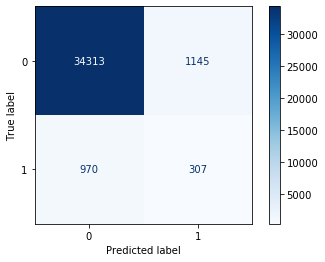

In [23]:
conceal_pred() #Decision Tree with no additional method

What is the data type to be predicted (audio, or video):  audio
Algorithm to be used for Classification (decisionTree, or randomForest):  decisionTree



 We're doing the extraction process
We are using decisionTree algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f):  InfoGain


[[29197  3128]
 [ 3226  1398]]
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     32325
         1.0       0.31      0.30      0.31      4624

    accuracy                           0.83     36949
   macro avg       0.60      0.60      0.60     36949
weighted avg       0.83      0.83      0.83     36949

Accuracy score is: 0.828033234999594
END of DecisionTree Classifier execution


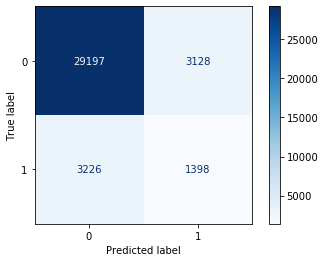

In [34]:
conceal_pred() #Decision Tree and InfoGain method

What is the data type to be predicted (audio, or video):  audio
Algorithm to be used for Classification (decisionTree, or randomForest):  decisionTree



 We're doing the extraction process
We are using decisionTree algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f):  anova_f


The feature selection method being used is anova_f
Reduced number of features using anova_f method: (80017, 30)
[[29313  3012]
 [ 3329  1295]]
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90     32325
         1.0       0.30      0.28      0.29      4624

    accuracy                           0.83     36949
   macro avg       0.60      0.59      0.60     36949
weighted avg       0.82      0.83      0.83     36949

Accuracy score is: 0.8283850713145146
END of DecisionTree Classifier execution


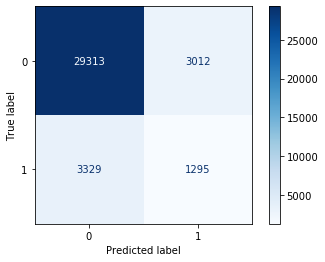

In [35]:
conceal_pred() #Decision Tree and Annova-f value method

What is the data type to be predicted (audio, or video):  audio
Algorithm to be used for Classification (decisionTree, or randomForest):  randomForest



 We're doing the extraction process
We are using randomForest algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f ):  ExtraTree


The feature selection method being used is ExtraTree
Reduced number of features after ExtraTree selection method: (80017, 35)
[[31852   473]
 [ 3690   934]]
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94     32325
         1.0       0.66      0.20      0.31      4624

    accuracy                           0.89     36949
   macro avg       0.78      0.59      0.62     36949
weighted avg       0.87      0.89      0.86     36949

Accuracy score is: 0.8873311862296679
END of Random Forest execution


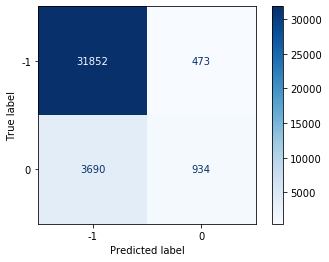

In [230]:
conceal_pred() #Random Forest and ExtraTree method

What is the data type to be predicted (audio, or video):  audio
Algorithm to be used for Classification (decisionTree, or randomForest):  randomForest



 We're doing the extraction process
We are using randomForest algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f ):  anova_f


The feature selection method being used is anova_f
Reduced number of features using anova_f method: (80017, 30)
[[31862   463]
 [ 3566  1058]]
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94     32325
         1.0       0.70      0.23      0.34      4624

    accuracy                           0.89     36949
   macro avg       0.80      0.61      0.64     36949
weighted avg       0.87      0.89      0.87     36949

Accuracy score is: 0.8909578067065415
END of Random Forest execution


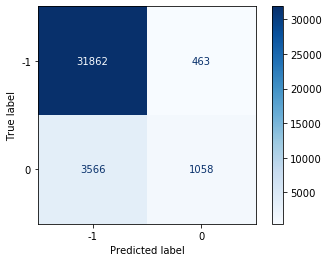

In [231]:
conceal_pred()   #RandomForest and annova-F method

What is the data type to be predicted (audio, or video):  audio
Algorithm to be used for Classification (decisionTree, or randomForest):  randomForest



 We're doing the extraction process
We are using randomForest algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f ):  corrCoeff


The feature selection method being used is corrCoeff
Reduced number of features after corrCoeff selection method: (80017, 35)
[[31892   433]
 [ 3678   946]]
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94     32325
         1.0       0.69      0.20      0.32      4624

    accuracy                           0.89     36949
   macro avg       0.79      0.60      0.63     36949
weighted avg       0.87      0.89      0.86     36949

Accuracy score is: 0.8887385314893502
END of Random Forest execution


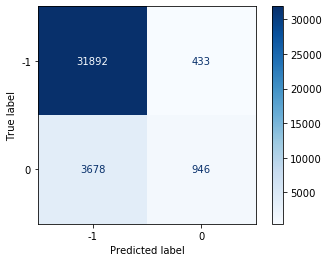

In [232]:
conceal_pred()     #RandomForest and correlation coefficient method

What is the data type to be predicted (audio, or video):  audio
Algorithm to be used for Classification (decisionTree, or randomForest):  randomForest



 We're doing the extraction process
We are using randomForest algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f ):  InfoGain


[[31850   475]
 [ 3568  1056]]
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94     32325
         1.0       0.69      0.23      0.34      4624

    accuracy                           0.89     36949
   macro avg       0.79      0.61      0.64     36949
weighted avg       0.87      0.89      0.87     36949

Accuracy score is: 0.8905789060597039
END of Random Forest execution


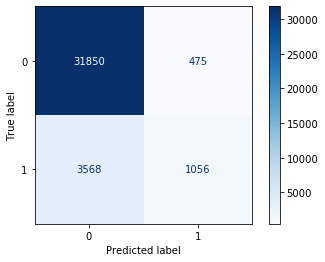

In [33]:
conceal_pred()     #RandomForest and InfoGain method

#### VIDEO

What is the data type to be predicted (audio, or video):  video
Algorithm to be used for Classification (decisionTree, or randomForest):  decisionTree



 We're doing the extraction process


Do you want 2 groups (0s and 1s) or 3 groups (0s, positives and negative):  3


We are using decisionTree algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f):  InfoGain


[[    0    24     4]
 [    9 34679   770]
 [    1   456    77]]
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        28
         0.0       0.99      0.98      0.98     35458
         1.0       0.09      0.14      0.11       534

    accuracy                           0.96     36020
   macro avg       0.36      0.37      0.36     36020
weighted avg       0.97      0.96      0.97     36020

Accuracy score is: 0.9649083842309828
END of DecisionTree Classifier execution


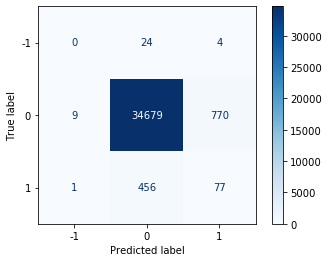

In [36]:
conceal_pred()          #DecTree, 3 groups, InfoGain method

What is the data type to be predicted (audio, or video):  video
Algorithm to be used for Classification (decisionTree, or randomForest):  decisionTree



 We're doing the extraction process


Do you want 2 groups (0s and 1s) or 3 groups (0s, positives and negative):  2


We are using decisionTree algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f):  InfoGain


[[34287  1171]
 [ 1010   267]]
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     35458
         1.0       0.19      0.21      0.20      1277

    accuracy                           0.94     36735
   macro avg       0.58      0.59      0.58     36735
weighted avg       0.94      0.94      0.94     36735

Accuracy score is: 0.9406288280930992
END of DecisionTree Classifier execution


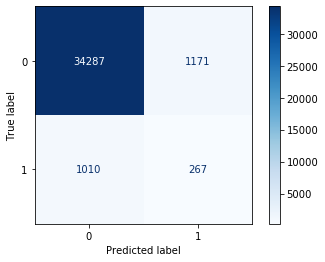

In [37]:
conceal_pred()          #DecTree, 2 groups, InfoGain method

What is the data type to be predicted (audio, or video):  video
Algorithm to be used for Classification (decisionTree, or randomForest):  decisionTree



 We're doing the extraction process


Do you want 2 groups (0s and 1s) or 3 groups (0s, positives and negative):  3


We are using decisionTree algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f):  anova_f


The feature selection method being used is anova_f
Reduced number of features using anova_f method: (94676, 30)
[[    1    26     1]
 [    9 34851   598]
 [    2   457    75]]
              precision    recall  f1-score   support

        -1.0       0.08      0.04      0.05        28
         0.0       0.99      0.98      0.98     35458
         1.0       0.11      0.14      0.12       534

    accuracy                           0.97     36020
   macro avg       0.39      0.39      0.39     36020
weighted avg       0.97      0.97      0.97     36020

Accuracy score is: 0.9696557468073292
END of DecisionTree Classifier execution


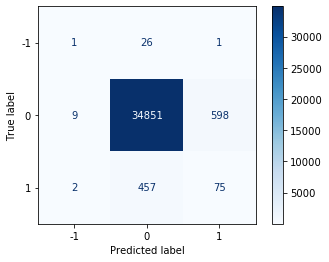

In [38]:
conceal_pred()          #DecTree, 3 groups, Annova f-value method

What is the data type to be predicted (audio, or video):  video
Algorithm to be used for Classification (decisionTree, or randomForest):  decisionTree



 We're doing the extraction process


Do you want 2 groups (0s and 1s) or 3 groups (0s, positives and negative):  2


We are using decisionTree algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f):  anova_f


The feature selection method being used is anova_f
Reduced number of features using anova_f method: (98468, 30)
[[34326  1132]
 [  964   313]]
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     35458
         1.0       0.22      0.25      0.23      1277

    accuracy                           0.94     36735
   macro avg       0.59      0.61      0.60     36735
weighted avg       0.95      0.94      0.94     36735

Accuracy score is: 0.9429426976997414
END of DecisionTree Classifier execution


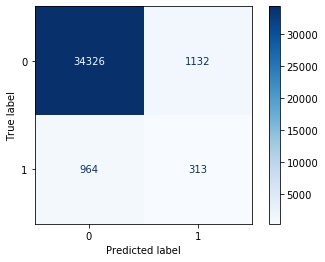

In [39]:
conceal_pred()          #DecTree, 2 groups, Annova f-value method

What is the data type to be predicted (audio, or video):  video
Algorithm to be used for Classification (decisionTree, or randomForest):  randomForest



 We're doing the extraction process


Do you want 2 groups (0s and 1s) or 3 groups (0s, positives and negative):  2


We are using randomForest algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f ):  ExtraTree


The feature selection method being used is ExtraTree
Reduced number of features after ExtraTree selection method: (98468, 35)
[[35218   240]
 [ 1171   106]]
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     35458
         1.0       0.31      0.08      0.13      1277

    accuracy                           0.96     36735
   macro avg       0.64      0.54      0.56     36735
weighted avg       0.94      0.96      0.95     36735

Accuracy score is: 0.96158976452974
END of Random Forest execution


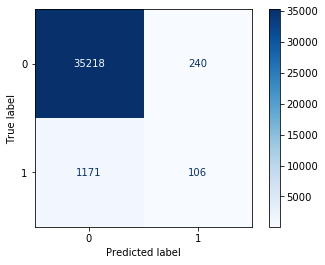

In [233]:
conceal_pred()          #RandomForest, 2 groups, ExtraTree method

What is the data type to be predicted (audio, or video):  video
Algorithm to be used for Classification (decisionTree, or randomForest):  randomForest



 We're doing the extraction process


Do you want 2 groups (0s and 1s) or 3 groups (0s, positives and negative):  3


We are using randomForest algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f ):  ExtraTree


The feature selection method being used is ExtraTree
Reduced number of features after ExtraTree selection method: (94676, 35)
[[    0    28     0]
 [    0 35391    67]
 [    0   511    23]]
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        28
         0.0       0.98      1.00      0.99     35458
         1.0       0.26      0.04      0.07       534

    accuracy                           0.98     36020
   macro avg       0.41      0.35      0.36     36020
weighted avg       0.97      0.98      0.98     36020

Accuracy score is: 0.9831760133259301
END of Random Forest execution


/home/det_tesi/ygurra/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/det_tesi/ygurra/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/det_tesi/ygurra/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


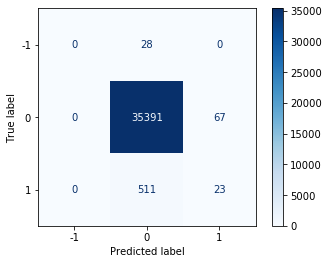

In [234]:
conceal_pred()     #RandomForest, 3 groups and Extra method

What is the data type to be predicted (audio, or video):  video
Algorithm to be used for Classification (decisionTree, or randomForest):  randomForest



 We're doing the extraction process


Do you want 2 groups (0s and 1s) or 3 groups (0s, positives and negative):  2


We are using randomForest algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f ):  anova_f


The feature selection method being used is anova_f
Reduced number of features using anova_f method: (98468, 30)
[[35295   163]
 [ 1209    68]]
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     35458
         1.0       0.29      0.05      0.09      1277

    accuracy                           0.96     36735
   macro avg       0.63      0.52      0.54     36735
weighted avg       0.94      0.96      0.95     36735

Accuracy score is: 0.9626514223492582
END of Random Forest execution


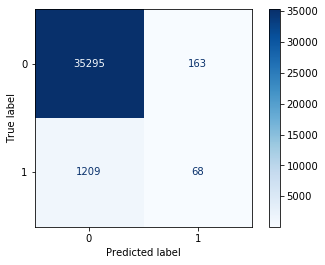

In [235]:
conceal_pred()     #RandomForest, 2 groups and annova-f method

What is the data type to be predicted (audio, or video):  video
Algorithm to be used for Classification (decisionTree, or randomForest):  randomForest



 We're doing the extraction process


Do you want 2 groups (0s and 1s) or 3 groups (0s, positives and negative):  3


We are using randomForest algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f ):  anova_f


The feature selection method being used is anova_f
Reduced number of features using anova_f method: (94676, 30)
[[    0    28     0]
 [    0 35387    71]
 [    0   508    26]]
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        28
         0.0       0.99      1.00      0.99     35458
         1.0       0.27      0.05      0.08       534

    accuracy                           0.98     36020
   macro avg       0.42      0.35      0.36     36020
weighted avg       0.97      0.98      0.98     36020

Accuracy score is: 0.9831482509716823
END of Random Forest execution


/home/det_tesi/ygurra/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/det_tesi/ygurra/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/det_tesi/ygurra/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


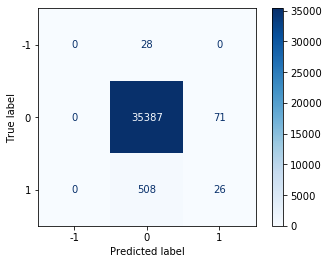

In [236]:
conceal_pred()     #RandomForest, 3 groups and annova-f method

What is the data type to be predicted (audio, or video):  video
Algorithm to be used for Classification (decisionTree, or randomForest):  randomForest



 We're doing the extraction process


Do you want 2 groups (0s and 1s) or 3 groups (0s, positives and negative):  2


We are using randomForest algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f ):  InfoGain


[[35249   209]
 [ 1169   108]]
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     35458
         1.0       0.34      0.08      0.14      1277

    accuracy                           0.96     36735
   macro avg       0.65      0.54      0.56     36735
weighted avg       0.95      0.96      0.95     36735

Accuracy score is: 0.9624880903770247
END of Random Forest execution


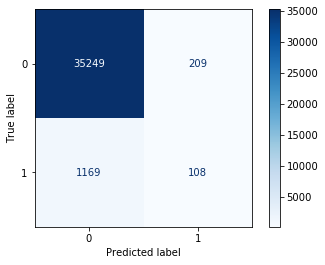

In [40]:
conceal_pred()     #RandomForest, 2 groups and InfoGain method

What is the data type to be predicted (audio, or video):  video
Algorithm to be used for Classification (decisionTree, or randomForest):  randomForest



 We're doing the extraction process


Do you want 2 groups (0s and 1s) or 3 groups (0s, positives and negative):  3


We are using randomForest algorithm


Do you want to do feature selection (yes or no):  yes
Which feature selection method do you want to use (ExtraTree, InfoGain, corrCoeff, anova_f ):  InfoGain


[[    0    28     0]
 [    0 35387    71]
 [    0   501    33]]
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        28
         0.0       0.99      1.00      0.99     35458
         1.0       0.32      0.06      0.10       534

    accuracy                           0.98     36020
   macro avg       0.43      0.35      0.37     36020
weighted avg       0.97      0.98      0.98     36020

Accuracy score is: 0.9833425874514159
END of Random Forest execution


/home/det_tesi/ygurra/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/det_tesi/ygurra/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/det_tesi/ygurra/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


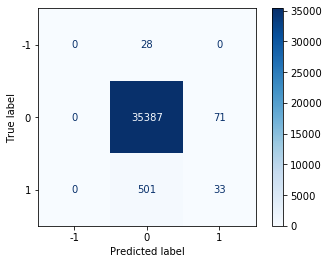

In [41]:
conceal_pred()     #RandomForest, 3 groups and InfoGain method

In [227]:
y_train.value_counts()

 0.0    92258
 1.0     2374
-1.0       44
Name: Vid_CONCEALMENT_Present?, dtype: int64

In [154]:
dataFrame["Vid_CONCEALMENT_Present?"].value_counts()

0.0    92258
1.0     6210
Name: Vid_CONCEALMENT_Present?, dtype: int64

In [228]:
dataFrame["exact_video_concealment"].value_counts().sum()

94676

#### Comment:
The best result for AUDIO seems to be achieved using RandomForest with Annova_f  feature selection technique.

What is the data type to be predicted (audio, or video):  audio
Algorithm to be used for Classification (decisionTree, xgboost, randomForest):  decisionTree



 We're doing the extraction process
We are using decisionTree algorithm


Do you want to do feature selection (yes or no):  no


[[29254  3071]
 [ 3226  1398]]
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     32325
         1.0       0.31      0.30      0.31      4624

    accuracy                           0.83     36949
   macro avg       0.61      0.60      0.61     36949
weighted avg       0.83      0.83      0.83     36949

Accuracy score is: 0.8295759019188611
END of DecisionTree Classifier execution
Adjusting the dataset in order to proceed with regression


Algorithm to be used(decisionTree, xgboost, randomForest):  decisionTree


R2 score is: 0.9135517804377273
Mean Absolute Error is: 0.35393386545039907


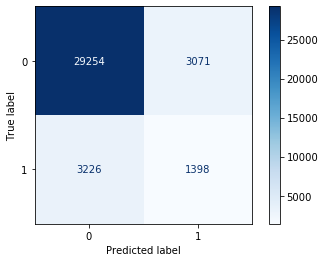

In [53]:
conceal_pred()

In [96]:
y_test.sum()

35964.0

In [37]:
dataFrame_1["exact_video_concealment"].value_counts()

 0.0      1220
 1.0        41
 2.0        18
 3.0         7
 7.0         6
 4.0         5
 6.0         3
 10.0        2
 9.0         2
 32.0        1
 13.0        1
 5.0         1
 8.0         1
 34.0        1
 11.0        1
-188.0       1
 12.0        1
 21.0        1
-117.0       1
Name: exact_video_concealment, dtype: int64

In [104]:
(dataFrame["exact_video_concealment"]>0).sum()

2374

#### Func-11) Main Function AUTOMATIC RUN

In [67]:
def conceal_pred():
    pred_type=["audio","video"]
    for typ in pred_type:
        
        class_algorithms=["decisionTree","randomForest"]      #2 possible algorithms to be used for classification
        for alg in class_algorithms:
            inp_data(typ)    #Prepare the dataset according to the data type (audio or video)
            classif(typ)     #Prepare the dataset (by removing certain missing and unsuitable data) in order to proceed with classification
            
            if alg == "decisionTree":   
                #print(f"We are using {alg} algorithm")
                #outlier=input("Do you want to exctract outliers(yes or no): ")
                for feat in ["no","yes"]:       #Usage of feature selection or not
                    
                    if feat == "yes":           #If feature selection is being used          
                        feat_sel_meth=["Pearson"]         #The list of possible feat selection methods for classification
                        for feat_val in feat_sel_meth:
                            feat_sel(feat_val, typ, "class")   #This is the first application of the feature selection to the Classification method           
                            dec_tree_class()
                            print("Done with DecisionTree Classification process")
                            
                            reg_algorithm=["decisionTree","randomForest"]
                            for alg_1 in reg_algorithm:
                                extract(typ)
                                regr(typ)
                                regre_inp_data(typ)
                                feat_sel(feat_val, typ, "reg")       #This is the second application of the feature selection to the Regression method
                                
                                if alg_1=="decisionTree":
                                    print(f"\nResults after {alg} classifier and {alg_1} regressor:")
                                    dec_tree_reg()
                    
                                elif alg_1=="randomForest":
                                    print(f"\nResults after {alg} classifier and {alg_1} regressor:")    
                                    rand_for_reg()
                    
                    else:                
                        dec_tree_class()
                        print("Done with DecisionTree Classiffication process")
                        
                        reg_algorithm=["decisionTree","randomForest"]
                        for alg_1 in reg_algorithm:
                            extract(typ)
                            regr(typ)
                            regre_inp_data(typ)
                            if alg_1=="decisionTree":
                                print(f"\nResults after {alg} classifier and {alg_1} regressor:")
                                dec_tree_reg()
                    
                            elif alg_1=="randomForest":
                                print(f"\nResults after {alg} classifier and {alg_1} regressor:")
                                rand_for_reg()
    
    
            elif alg == "randomForest":                                                   #Check the input value and accordingly apply the next steps
                print(f"We are using {alg} algorithm")
                #outlier=input("Do you want to exctract outliers(yes or no): ")
                for feat in ["no","yes"]:  

                    if feat == "yes":              
                        feat_sel_meth=["Pearson"]
                        for feat_val in feat_sel_meth:
                            feat_sel(feat_val, typ, "class")   #This is the first application of the feature selection to the Classification method           
                            rand_for_class()
                            #print("END of RandomForest Classifier execution")
                            extract(typ)
                            regr(typ)
                            regre_inp_data(typ)
                            feat_sel(feat_val, typ, "reg")       #This is the second application of the feature selection to the Regression method
                            reg_algorithm=["decisionTree","randomForest"]
                            for alg_1 in reg_algorithm:
                                if alg_1=="decisionTree":
                                    print(f"Results after {alg} classifier and {alg_1} regressor:")
                                    dec_tree_reg()
                    
                                elif alg_1=="randomForest":
                                    print(f"Results after {alg} classifier and {alg_1} regressor:")    
                                    rand_for_reg()
                    
                    else:                
                        dec_tree_class()
                        #print("END of DecisionTree Classifier execution")
                        extract(typ)
                        regr(typ)
                        reg_algorithm=["decisionTree","randomForest"]
                        regre_inp_data(typ)
                        for alg_1 in reg_algorithm:
                            if alg_1=="decisionTree":
                                print(f"Results after {alg} classifier and {alg_1} regressor:")
                                dec_tree_reg()
                    
                            elif alg_1=="randomForest":
                                print(f"Results after {alg} classifier and {alg_1} regressor:")
                                rand_for_reg()
    

In [68]:
conceal_pred()

[[36949]]
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00     36949

    accuracy                           1.00     36949
   macro avg       1.00      1.00      1.00     36949
weighted avg       1.00      1.00      1.00     36949

Accuracy score is: 1.0
Done with DecisionTree Classiffication process

 We're doing the extraction process
Adjusting the dataset in order to proceed with regression

Results after decisionTree classifier and decisionTree regressor:
R2 score is: 0.9997396322703287
Mean Absolute Error is: 0.00011141130267665655

 We're doing the extraction process
Adjusting the dataset in order to proceed with regression

Results after decisionTree classifier and randomForest regressor:
R2 score is: 0.9995512879659593
Mean Absolute Error is: 0.00024301590396345757
Mean Squared Error: 0.0002860171851934382
Feature selection for classification is being used


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([   319,    636,   2048,   3357,   5666,\n            ...\n            107569, 111565, 112564, 113563, 114562],\n           dtype='int64', length=1218). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

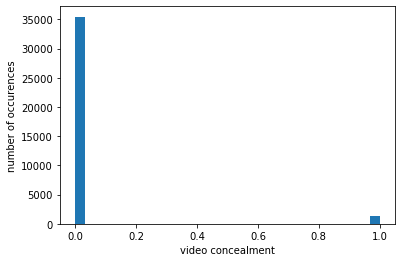

In [21]:
plt.hist(y_test, bins=30)
plt.xlabel("video concealment")
plt.ylabel("number of occurences")
plt.show()

In [20]:
y_test.value_counts()

 0.0      19910
 1.0        223
 2.0        101
 3.0         41
 4.0         23
 5.0         14
 7.0         11
 9.0          8
 6.0          8
 8.0          6
 11.0         5
 10.0         5
-9.0          2
-36.0         2
 47.0         2
 32.0         2
 12.0         2
 21.0         2
 34.0         2
 24.0         1
-1.0          1
-16.0         1
 14.0         1
-6.0          1
-103.0        1
 59.0         1
-117.0        1
-25.0         1
 23.0         1
 38.0         1
-188.0        1
-10.0         1
-20.0         1
-40.0         1
-165.0        1
 35.0         1
-107.0        1
 31.0         1
 30.0         1
 15.0         1
Name: exact_video_concealment, dtype: int64

In [37]:
X_train.shape

(66417, 30)

#### Question: 
Do I need to use feature selection for both: Classification and Regression ? 

#### Audio Regression Experiment:

##### Before we start with this technique we should notice that "concealmentEvents" and "framesDropped" fields have their concealment values in cumulative form, which means that they are sum of their previous values. In order to extract the exact values for each packet we'll follow the note below:

##### NOTE: Group according to the flow and pcap columns (using "grouby" command) and then take the difference between the current concealment value and the previous one (using .diff command) because the concealment values in both columns ("concealmentEvents" and "framesDropped") extracted from RETINA are in a cumulative form (so summed up of the previous values). By doing this we extract the exact concealment value for each packet.